# RECONOCIMIENTO FACIAL

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

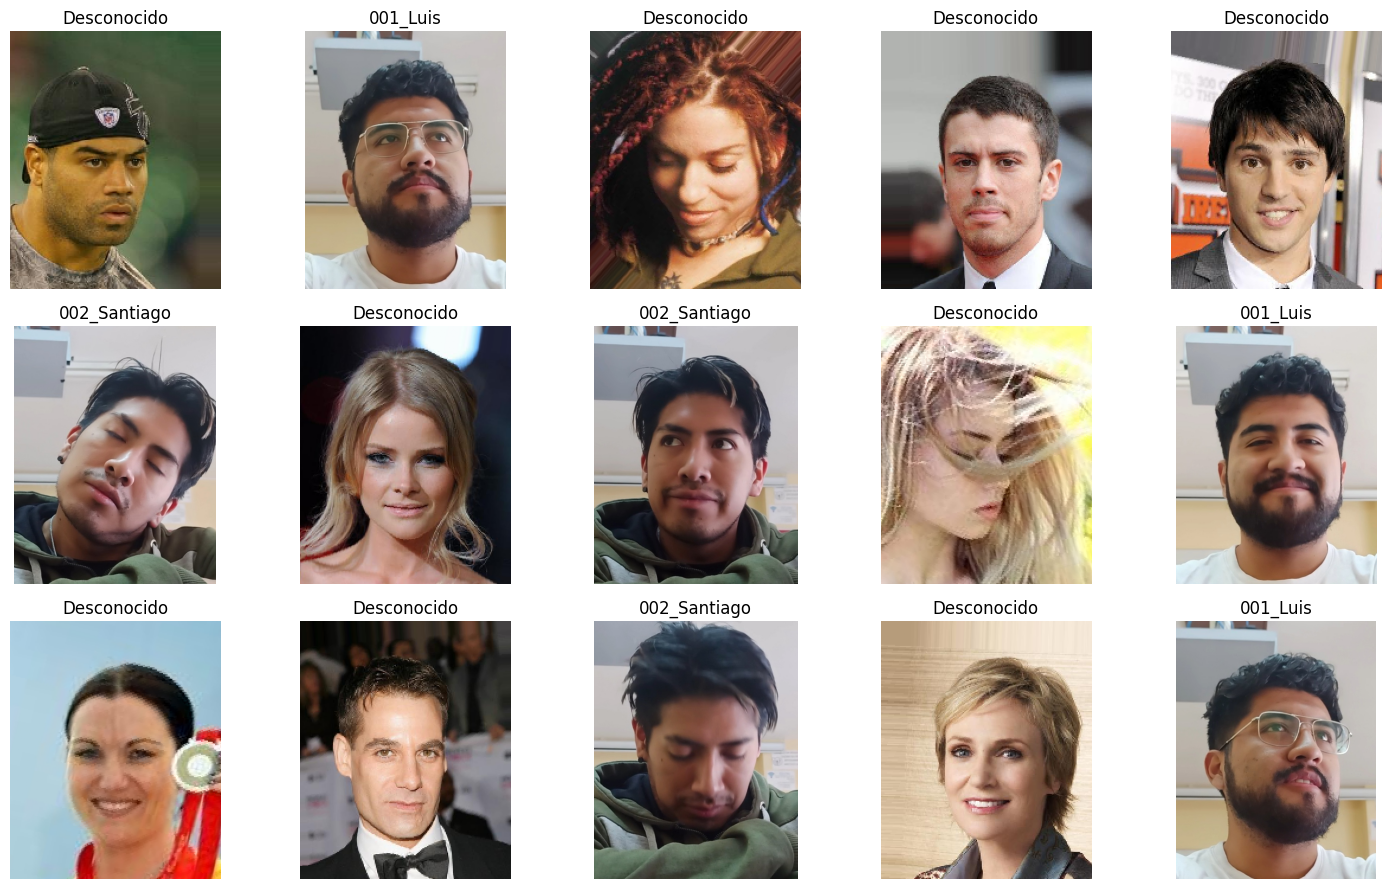

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Rutas de los datos
fotos_mias = "dataset/propias/"  # Tus fotos
CelebA = "dataset/celeba/"  # CelebA

# Listado de carpetas en fotos_mias (asumimos que cada carpeta es una persona)
fotos_mias_folders = os.listdir(fotos_mias)

# Listado de archivos de CelebA
CelebA_files = os.listdir(CelebA)

# Seleccionar 15 imágenes aleatorias
total_images = 15
selected_images = []

# Seleccionar imágenes de fotos_mias
for folder in fotos_mias_folders:
    folder_path = os.path.join(fotos_mias, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        for img in images:
            selected_images.append((os.path.join(folder_path, img), folder))

# Seleccionar imágenes de CelebA
for img in CelebA_files[:200]:  # Seleccionar solo las primeras 200 imágenes
    selected_images.append((os.path.join(CelebA, img), "Desconocido"))

# Seleccionar 15 imágenes aleatorias
selected_images = random.sample(selected_images, total_images)

# Plotear las imágenes
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for (img_path, label), ax in zip(selected_images, axes):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import os
import numpy as np

# Listas para los archivos y las etiquetas
fotos_mias_files = []
fotos_mias_attri = []

# Asignar una etiqueta única a cada persona basada en el valor numérico de la carpeta
for folder in fotos_mias_folders:
    folder_path = os.path.join(fotos_mias, folder)
    if os.path.isdir(folder_path):
        # Extraer el número del nombre de la carpeta (asumiendo formato 001_Nombre)
        folder_number = int(folder.split('_')[0])
        
        # Listar todas las imágenes dentro de la subcarpeta
        files_in_folder = os.listdir(folder_path)
        for file in files_in_folder:
            fotos_mias_files.append(os.path.join(fotos_mias, folder, file))  # Ruta completa de la imagen
            fotos_mias_attri.append(folder_number)  # Asignar una etiqueta basada en el número de la carpeta

fotos_mias_files = np.array(fotos_mias_files)
fotos_mias_attri = np.array(fotos_mias_attri)

# Etiquetas para CelebA (0 para CelebA)
CelebA_attri = np.zeros(len(CelebA_files), dtype="int")

# Imprimir los arrays generados
print("fotos_mias_files_array:")
print(fotos_mias_files)

print("\nfotos_mias_attri_array:")
print(fotos_mias_attri)

print("\nCelebA_files:")
print(CelebA_files)

print("\nCelebA_attri:")
print(CelebA_attri)

fotos_mias_files_array:
['dataset/propias/001_Luis\\face_0000.jpg'
 'dataset/propias/001_Luis\\face_0001.jpg'
 'dataset/propias/001_Luis\\face_0002.jpg'
 'dataset/propias/001_Luis\\face_0003.jpg'
 'dataset/propias/001_Luis\\face_0004.jpg'
 'dataset/propias/001_Luis\\face_0005.jpg'
 'dataset/propias/001_Luis\\face_0006.jpg'
 'dataset/propias/001_Luis\\face_0007.jpg'
 'dataset/propias/001_Luis\\face_0008.jpg'
 'dataset/propias/001_Luis\\face_0009.jpg'
 'dataset/propias/001_Luis\\face_0010.jpg'
 'dataset/propias/001_Luis\\face_0011.jpg'
 'dataset/propias/001_Luis\\face_0012.jpg'
 'dataset/propias/001_Luis\\face_0013.jpg'
 'dataset/propias/001_Luis\\face_0014.jpg'
 'dataset/propias/001_Luis\\face_0015.jpg'
 'dataset/propias/001_Luis\\face_0016.jpg'
 'dataset/propias/001_Luis\\face_0017.jpg'
 'dataset/propias/001_Luis\\face_0018.jpg'
 'dataset/propias/001_Luis\\face_0019.jpg'
 'dataset/propias/001_Luis\\face_0020.jpg'
 'dataset/propias/001_Luis\\face_0021.jpg'
 'dataset/propias/001_Luis\\fa

In [4]:
import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import numpy as np

ih = 128
iw = 128

percent = 0.15

BATCH_SIZE = 32
epochs = 20

N_d = 100

STEPS_PER_EPOCH =  int(((len(fotos_mias_folders)+1)*N_d*(1-percent)) // BATCH_SIZE)
VALIDATION_STEPS = int(((len(fotos_mias_folders)+1)*N_d * percent) // BATCH_SIZE)
#==============================================================================
#                               procesamiento de Datos


fotos_mias_files = tf.data.Dataset.from_tensor_slices(fotos_mias_files)
fotos_mias_attri = tf.data.Dataset.from_tensor_slices(fotos_mias_attri)
CelebA_files = tf.data.Dataset.from_tensor_slices(CelebA_files)
CelebA_attri = tf.data.Dataset.from_tensor_slices(CelebA_attri)

fotos_mias_data = tf.data.Dataset.zip((fotos_mias_files,fotos_mias_attri))
CelebA_data = tf.data.Dataset.zip((CelebA_files,CelebA_attri))

def process_file_fotos_mias(file_name, fotos_mias_attri):
    print(fotos_mias)
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [ih,iw])
    image /= 255.0
    return image, fotos_mias_attri

def process_file_CelebA(file_name, CelebA_attri):
    image = tf.io.read_file(CelebA + file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [ih,iw])
    image /= 255.0
    return image, CelebA_attri

labeled_images_fotos_mias = fotos_mias_data.map(process_file_fotos_mias)
labeled_images_CelebA = CelebA_data.map(process_file_CelebA)

labeled_images = labeled_images_fotos_mias.concatenate(labeled_images_CelebA)
labeled_images = labeled_images.shuffle((len(fotos_mias_folders)+1)*N_d)

print('=======================================================================')

print('labeled_images:')
print(labeled_images)
print('labeled_images_len:')
print(len(labeled_images))

print('=======================================================================')

dataset_size = int(N_d* (len(fotos_mias_folders)+1)* (1-percent))

training_data = labeled_images.take(dataset_size)
training_data = training_data.repeat().batch(BATCH_SIZE)

test_data = labeled_images.skip(dataset_size)
test_data = test_data.repeat().batch(BATCH_SIZE)

print('=======================================================================')
print('split dataset in training and test data')

print('training_data')
print(training_data)

print('test_data')
print(test_data)

print('=======================================================================')
#==============================================================================

dataset/propias/
labeled_images:
<_ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
labeled_images_len:
50200
split dataset in training and test data
training_data
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
test_data
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Número de clases (usuarios)
num_classes = len (fotos_mias_folders) +1  # Ajusta esto al número de usuarios en tu conjunto de datos

# Cargar el modelo preentrenado
pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Crear un nuevo modelo
model = Sequential()

# Añadir las capas preentrenadas al nuevo modelo
for layer in pre_trained_model.layers:
    model.add(layer)

# Añadir nuevas capas al modelo
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))  # Cambiar a softmax para múltiples clases

# Congelar las capas preentrenadas
for layer in model.layers[:-4]:  # Congelar todas las capas excepto las últimas 4
    layer.trainable = False

# Compilar el modelo
model.compile(loss="sparse_categorical_crossentropy",  # Cambiar a sparse_categorical_crossentropy
              optimizer=Adam(),
              metrics=["accuracy"])

model.summary()

# Configurar TensorBoard
log_dir = "redes_entrenadas/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenar el modelo
history = model.fit(
    training_data,
    epochs=epochs,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=test_data,
    validation_steps=VALIDATION_STEPS,
    callbacks=[tensorboard_callback]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,843 (60.16 MB)

 Trainable params: 1,057,155 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4833 - loss: 1.0019 - val_accuracy: 1.0000 - val_loss: 0.0552
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9916 - loss: 0.0649 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 8.7560e-05
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.6320e-05
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 8.6478e-05
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 2.1773e-05

In [6]:
# Sobrescribir los archivos existentes al guardar los pesos y el modelo
model.save("redes_entrenadas/ReconocimientoFacial.h5")
model.save_weights("../TALLER3/redes_entrenadas/model.weights.h5")

In [4]:
# Para visualizar los resultados de TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22208), started 15:04:56 ago. (Use '!kill 22208' to kill it.)